# Seq2Seq model with Bahdanau attention
在这个notebook当中，我会先不尝试参考开源方案，然后采取自己先思考的模式，尝试将代码写出

## Seq2seq知识点总结

- 结构：
    - 1. encoder: BiLSTM模型
    - 2. decoder：BiLSTM模型

- 训练过程
    - 1. encoder部分：假设有输入英文序列 X = ["<SOS>","I","Love","You","<EOS>"], 
        - 1. 首先是将 $x_0$ 输入到 embedding 层：$ input_t^e= embedding(x_t)$
        - 2. 接下来初始化 $h_0$, $h_0$ 是一个全零向量
        - 3. 将生成的 $ input_t^e$ 和 $h_0$ 输入到 RNN模型内，获得全新的$h_1$， $h_1 = RNN(input_t^e, h_0)$
        - 4. 依次操作，并且将$h_1,h_2,...,h_T$保存好作为下面attention机制需要的部分
    
    - 2. decoder部分：假设输入是法语序列 Y = ["<SOS>","Je","t","aime","<EOS>"]
        - 1. 首先要明确几个概念，decoder也是GRU，只不过GRU的输入经过加性attention机制进行修改了
            - decoder的输入跟encoder是一样的，时间步s的 $input_s^d$，上一个时刻的隐藏状态 $h_s$
        - 2. 基本的过程可以先用语言描述清楚：
            - 当s=0，$Y_0=<SOS>$,先计算出来过去的T个$h_i$与$Y_0$之间的相关程度，及注意力得分 $e^s_t$
            - 然后将所有 $e^s_t$ 给综合起来，然后归一化为注意力权重
            - 生成上下文向量
$$
\begin{aligned}
e_s^{\text{dec}} &= \text{Embedding}(y_{s-1}^{\text{true}}) \quad \in \mathbb{R}^d \\
\bar{e}_s &= \left[ e_s^{\text{dec}};\ c_s \right] \quad \in \mathbb{R}^{d + 2h} \\
s_s^{\text{dec}} &= \text{GRU}\left( \bar{e}_s,\ s_{s-1}^{\text{dec}} \right) \quad \in \mathbb{R}^h \\
p(y_s \mid y_{1:s-1}, X) &= \text{softmax}\left( W_o \left[ s_s^{\text{dec}};\ c_s \right] + b_o \right) \quad \in \mathbb{R}^V
\end{aligned}
$$

## Seq2Seq 代码实现函数整合

- 清理数据
    - 统一大小写
    - 不要符号
    - 控制sentence长度
- 创建数据集
    - 创建源语言的词库
    - 创建目标语言的词库
    - 创建pair词对
    - 根据词对创建word_tensor，包括text_tensor, target_tensor
    - 创建dataloader函数
    - 创建随机batch生成函数
- 创建encoder和decoder类
    - encoder:
        - encoder parameters:
            - self.embedding_layer
            - self.gru_model
            - self.hidden_state
        - encoder forward:
            - embedded = self.embedding_layer(text_tensor)
            - output, hidden_state = self.gru_model(embedded, hidden_state)
            - return output, hidden_state
    - decoder:
        - decoder parameters:
            - self.hidden_size
            - self.output_size
            - self.embedding_layer(targt_word_size, hidden_size)
            - self.gru_model(hidden_size,hidden_size, batch_first=True)
            - self.output_layer(hidden_size, output_size)
            - self.dropout(dropout_p)
        - decoder forward_step:
            - embedded = self.embedding_layer(target_tensor)
            - embedded = F.relu(embedded)
            - output, hidden_state = self.gru_model(embedded, hidden_state)
            - output = self.output_layer(output)
            - return output, hidden_state
        - decoder forward:
            - decoder_hidden_state = encoder_hidden_state
            - decoder_input = <SOS>
            - decoder_outputs = []
            - for i in range(MAX_LENGTH):
                - decoder_output, decoder_hidden_state = forward_step(decoder_input, decoder_hidden_state)
                - decoder_outputs.append(decoder_output)
                    - $t$ time step 产生了 output，更新了hidden_state
                - 开始下一轮输入：
                    - 如果是训练stage，将 decoder_input = Y[i]
                    - 如果不是，则是：
                        - _, topi = decoder_output.topk(1)
                        - decoder_input = topi.squeeze(-1).detach()
            - decoder_outputs = torch.cat(decoder_outputs), # 整合所有输出
            - decoder_outputs = F.log_softmax(decoder_outputs), # 这里不理解
            - return decoder_outputs, decoder_hidden
- 创建训练函数：
    - 设置optimizer,criterion
    - 设置num_epoch, learning_rate
    - for epoch in range(num_epoch):
        - 随机获取一个batch的语言对，batch_size=64
        - for data in dataLoader: 相当于是在整个数据集上训练
            - text_tensor, label_tensor, text, label = pair
            - text_tensor, label_tensor = text_tensor.to(device), label_tensor.to(device)
            - encoder_outputs, encoder_hidden = encoder(parameters)
            - decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden,label_tensor)
            - 计算loss， loss = criterion(label_tensor,decoder_outputs)
            - 反向传播, loss.backward()
            - 更新参数, encoder_optimizer.step(), decoder_optimizer.step()
            - 累加损失，total_loss += loss.item()
            - 损失取平均

# 1. 整体代码实现

## 问题：
1. `all_letters = string.ascii_letters + " .,;'-"`，所有的字符都是这些吗？那么中文字符怎么办
2. `unicodeToAscii(s)`，这个函数的具体步骤该如何理解？
3. `re.sub`，re的配词方式？
4. `open("data/%s-%s.txt" % (lang1, lang2), encoding='utf-8').read().strip().split('\n')`，为何要有这么多操作
5. `pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]`，具体是怎么实现的
6. `filterPairs(pairs)`，算法实现太恶心，我还是改成比较好看的
7. 其实数据处理这个部分完全可以写成专门的class
8. BahdanauAttention的机制现在才搞懂：
    - 注意力机制的输入参数有：当前时间s的decoder hidden，过去T时间步的encoder_outputs
    - encoder_outputs shape = (batch_size, seq_len, hidden_size)， 就是说包含有seq_len个hidden_state
    - 最终生成的上下文向量context vector有点类似于之前的encoder_hidden
    - 

In [25]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import time
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1
all_letters = string.ascii_letters + " .,;'-" # 所有的字典只有这个吗？
n_letters = len(all_letters)
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", 
    "i m ",
    "he is", 
    "he s ",
    "she is", 
    "she s ",
    "you are", 
    "you re ",
    "we are", 
    "we re ",
    "they are", 
    "they re "
)

class Lang:
    def __init__(self,name):
        self.name = name
        self.word2index = {} # 全词典唯一
        self.index2word = {} # 全词典唯一
        self.word2count = {} # 会更改
        self.n_words = 0
    
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

# 没理解参数
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def normalizeString(s):
    # 调用 unicodeToAscii 并将字符串转换为小写，去除首尾空格
    s = unicodeToAscii(s.lower().strip())
    # 在标点符号前后添加空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 将非字母字符替换为空格
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    # 去除多余的空格并返回结果
    return s.strip()

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # read the file and split into lines
    lines = open("data/%s-%s.txt" % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

def filterPair(p):
    """
    parameters:
    - p: 一个包含两个字符串的列表或元组，代表一个句子对
    - 功能：
        - 检查句子的单词数小于 MAX_LENGTH（即10个单词）
        - 检查英语句子（p[1]）是否以 eng_prefixes 中的任何一个前缀开头。
    """
    
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    """
    功能：
        - 使用列表推导式遍历 pairs 中的每一个句子对，并调用 filterPair 函数进行筛选。
        - 返回一个新的列表，其中只包含通过 filterPair 筛选后的句子对。
    """

    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" %len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1,-1)

def tensorFromPair(input_lang, output_lang, pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

def get_dataloader(batch_size, split_ratio=[0.7,0.15,0.15]):
    input_lang, output_lang, pairs = prepareData("eng","fra",True)
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.uint32)
    output_ids = np.zeros((n, MAX_LENGTH), dtype=np.uint32)

    for idx, (input, output) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang,input)
        out_ids = indexesFromSentence(output_lang,output)
        inp_ids.append(EOS_token)
        out_ids.append(EOS_token)
        input_ids[idx,:len(inp_ids)] = inp_ids
        output_ids[idx, :len(out_ids)] = out_ids
    
    # 转化为pytorch数据集
    full_dataset = TensorDataset(torch.LongTensor(input_ids).to(device),
                                torch.LongTensor(output_ids).to(device))
    # 划分数据集
    train_size = int(split_ratio[0]*n)
    val_size = int(split_ratio[1]*n)
    test_size = n - train_size - val_size

    generator = torch.Generator().manual_seed(42)

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=generator
    )

    # 创建dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

    return input_lang, output_lang, train_loader, val_loader, test_loader

    #train_sampler = RandomSampler(train_data)
    #train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    #return input_lang, output_lang, train_dataloader

class GRUencoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout_p):
        super(GRUencoder,self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding_layer = nn.Embedding(self.embedding_size, self.hidden_size)
        self.gru_encoder = nn.GRU(self.hidden_size,self.hidden_size,batch_first=True) # batch_size, sequence_length, hidden_size
        self.dropout = nn.Dropout(dropout_p)
    def forward(self, input_tensor):
        embedded = self.dropout(self.embedding_layer(input_tensor))
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)
        return encoder_outputs, encoder_hidden

class GRUdecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout_p):
        super(GRUdecoder,self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding_layer = nn.Embedding(self.embedding_size, self.hidden_size)
        self.gru_decoder = nn.GRU(self.hidden_size, self.hidden_size)
        self.output_layer = nn.Linear(self.hidden_size, self.embedding_size)
    
    def step(self, input_tensor, decoder_hidden):
        embedded = self.embedding_layer(input_tensor)
        embedded = F.relu(embedded)
        decoder_output, decoder_hidden = self.gru_decoder(embedded, decoder_hidden)
        decoder_output = self.output_layer(decoder_output)
        return decoder_output, decoder_hidden
    
    def forward(self, encoder_outputs, encoder_hidden, label_tensors=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            if label_tensors is not None: # teacher forcing
                decoder_input = label_tensors[:,i].unsqueeze(1)
            else:
                # 推理阶段 
                _, topi = decoder_output.topk(1) # 这个作用至今没搞明白
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1) # 不是很理解？
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1) # 不是很理解这一步
        return decoder_outputs, decoder_hidden, None   

class BahdanauAttention(nn.Module):
    def __init__(self,hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W_s = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_h = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V   = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        :param decoder_hidden: 解码器隐藏状态(batch_size, hidden_size)
        :param encoder_outputs: 隐藏层所有时间步的隐藏状态(batch_size, seq_len, hidden_size)
        :return: context vector (batch_size, hidden_size)和注意力权重(batch_size, seq_len)
        """
        batch_size, seq_len, hidden_size = encoder_outputs.size()

        # 将解码器隐藏状态扩展为 (batch_size, seq_len, hidden_size)
        decoder_hidden_expanded = self.W_s(decoder_hidden).permute(1, 0, 2)
        
        # 对编码器隐藏状态进行线性变换
        encoder_transformed = self.W_h(encoder_outputs)

        # 计算注意力得分 (batch_size, seq_len, hidden_size)
        energy = torch.tanh(decoder_hidden_expanded + encoder_transformed)

        # 注意力得分的标量值，(batch_size, seq_len)
        attention_scores = self.V(energy).squeeze(2)

        # 注意力权重
        attention_weights = F.softmax(attention_scores, dim=1)

        # 计算上下文向量 (batch_size, hidden_size)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context_vector, attention_weights

class AttnGRUdecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout_p):
        super(AttnGRUdecoder, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Embedding(self.embedding_size, self.hidden_size)
        self.attention_layer = BahdanauAttention(self.hidden_size)
        self.gru_decoder = nn.GRU(2*self.hidden_size, self.hidden_size, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, self.embedding_size)
        self.dropout = nn.Dropout(dropout_p)
    
    def Step(self, decoder_input, decoder_hidden, encoder_outputs):
        embedded_input = self.embedding_layer(decoder_input)
        embedded_input = self.dropout(embedded_input)
        context_vector, attention_weights = self.attention_layer(decoder_hidden, encoder_outputs)
        context_vector = context_vector.unsqueeze(1)
        # 将上下文向量与嵌入向量拼接

        rnn_input = torch.cat([embedded_input, context_vector], dim=2)

        # 更新解码器隐藏状态
        decoder_output, decoder_hidden = self.gru_decoder(rnn_input,decoder_hidden)

        # 生成输出
        output = self.output_layer(decoder_output)

        return output, decoder_hidden, attention_weights
    
    def forward(self, encoder_outputs, encoder_hidden, label_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_hidden = encoder_hidden
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_outputs = []
        attention_weights_list = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attention_weights = self.Step(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output)
            attention_weights_list.append(attention_weights)

            if label_tensor is not None: # teacher forcing
                decoder_input = label_tensor[:,i].unsqueeze(1)
            else:
                _,topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attention_weights_list = torch.stack(attention_weights_list, dim=1)

        return decoder_outputs, decoder_hidden, attention_weights_list


def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        # 已经上device了
        input_tensor, output_tensor = data

        # 为何要先做一个zero_grad
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, attention_weigths_list = decoder(encoder_outputs, encoder_hidden, output_tensor)

        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)),
                         output_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# 添加evaluate函数


def Train(train_dataloader, encoder, decoder, n_epoch, lr, print_every=100, plot_every=100):
    start = time.time()
    plot_loss = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    criterion = nn.NLLLoss()

    for epoch in range(n_epoch):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print(loss)

hidden_size = 128
batch_size = 64
n_epoch = 80
lr = 0.001
input_lang, output_lang, train_dataloader, val_dataloader, test_dataloader = get_dataloader(batch_size=batch_size)

encoder = GRUencoder(embedding_size=input_lang.n_words, hidden_size=hidden_size, dropout_p=0.1).to(device)
decoder = AttnGRUdecoder(embedding_size=output_lang.n_words, hidden_size=hidden_size, dropout_p=0.1).to(device)

Train(train_dataloader, encoder, decoder, n_epoch, lr)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11464 sentence pairs
Counting words...
Counted words:
fra 4625
eng 2986
3.2526071998808117
2.206421777369484
1.873087343715486
1.6508250520342873
1.4923472518012637
1.3690206427422782
1.2609326976632316
1.1630807746024359
1.0748542556687006
0.9902430134160178
0.9150965956468431
0.8452966061849443
0.7799970583310203
0.7192841720959496
0.6653049843651908
0.6143809618457915
0.5674833026197221
0.52468122636515
0.4836691019553987
0.4455168888209358
0.4131907688246833
0.38252206052106524
0.35126836290435187
0.3257666007866935
0.30282454736649045
0.2808105284495959
0.2589982415712069
0.24077405579506406
0.22338746499920648
0.20659774790207544
0.19186578974837348
0.17859466208351982
0.16772340924020798
0.1576921580329774
0.14508117569817436
0.13722484937262913
0.12974094493048532
0.1203674768644666
0.11565005773353199
0.10599206979312593
0.10078761513744082
0.09576661328947733
0.09003517747161881
0.08564391915523817
0.08090495131909847
0.0

In [53]:
def Train_with_Validation(train_dataloader, val_dataloader, encoder, decoder, n_epoch, lr, patience):
    # 初始化优化器和损失函数
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    avg_train_loss = 0
    avg_val_loss = 0
    best_val_loss = float('inf')
    epochs_no_imporve = 0

    for epoch in range(n_epoch):
        # ===训练阶段===
        encoder.train()
        decoder.train()
        train_loss = 0

        for batch_input, batch_output in train_dataloader:
            # 梯度清零
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # 前向传播
            encoder_outputs, encoder_hidden = encoder(batch_input)
            decoder_outputs, decoder_hidden, attentions = decoder(encoder_outputs, encoder_hidden, batch_output)

            # 计算损失
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                batch_output.view(-1)
            )

            # 反向传播
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)

            # 参数更新
            encoder_optimizer.step()
            decoder_optimizer.step()

            # 记录损失
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_dataloader)

        # =====验证接断======
        encoder.eval()
        decoder.eval()
        
        val_loss = 0

        with torch.no_grad(): # 禁用梯度计算
            for batch_input, batch_output in val_dataloader:
                encoder_outputs, encoder_hidden = encoder(batch_input)
                decoder_outputs,_,attentions = decoder(encoder_outputs, encoder_hidden)

                loss = criterion(
                    decoder_outputs.view(-1, decoder_outputs.size(-1)),
                    batch_output.view(-1)
                )
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
         
        #======早停机制和模型保存机制======
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_imporve = 0
            # 保存最佳模型
            torch.save(encoder.state_dict(), "/harddisk1/SZC-Project/NLP-learning/RNNs/model_saved/best_encoder.pth")
            torch.save(decoder.state_dict(), "/harddisk1/SZC-Project/NLP-learning/RNNs/model_saved/best_decoder.pth")
        else:
            epochs_no_imporve += 1
            if epochs_no_imporve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # ========打印进度=========
        print(f'Epoch [{epoch+1}/{n_epoch}]')
        print(f'Train Loss:{avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print("-"*30)

hidden_size = 128
batch_size = 64
n_epoch = 80
lr = 0.001
patience = 20
input_lang, output_lang, train_dataloader, val_dataloader, test_dataloader = get_dataloader(batch_size=batch_size)

encoder = GRUencoder(embedding_size=input_lang.n_words, hidden_size=hidden_size, dropout_p=0.1).to(device)
decoder = AttnGRUdecoder(embedding_size=output_lang.n_words, hidden_size=hidden_size, dropout_p=0.1).to(device)

Train_with_Validation(train_dataloader, val_dataloader,encoder, decoder, n_epoch, lr, patience)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11464 sentence pairs
Counting words...
Counted words:
fra 4625
eng 2986
Epoch [1/80]
Train Loss:3.1127 | Val Loss: 3.3324
------------------------------
Epoch [2/80]
Train Loss:2.0503 | Val Loss: 3.0270
------------------------------
Epoch [3/80]
Train Loss:1.7511 | Val Loss: 2.8848
------------------------------
Epoch [4/80]
Train Loss:1.5519 | Val Loss: 2.8014
------------------------------
Epoch [5/80]
Train Loss:1.4074 | Val Loss: 2.7843
------------------------------
Epoch [6/80]
Train Loss:1.2840 | Val Loss: 2.7602
------------------------------
Epoch [7/80]
Train Loss:1.1768 | Val Loss: 2.7375
------------------------------
Epoch [8/80]
Train Loss:1.0779 | Val Loss: 2.5805
------------------------------
Epoch [9/80]
Train Loss:0.9902 | Val Loss: 2.5350
------------------------------
Epoch [10/80]
Train Loss:0.9081 | Val Loss: 2.4555
------------------------------
Epoch [11/80]
Train Loss:0.8351 | Val Loss: 2.4232
-----------

/tmp/ipykernel_3611862/4128756261.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('/harddisk1/SZC-Project/NLP-learning/RNNs/model_sa

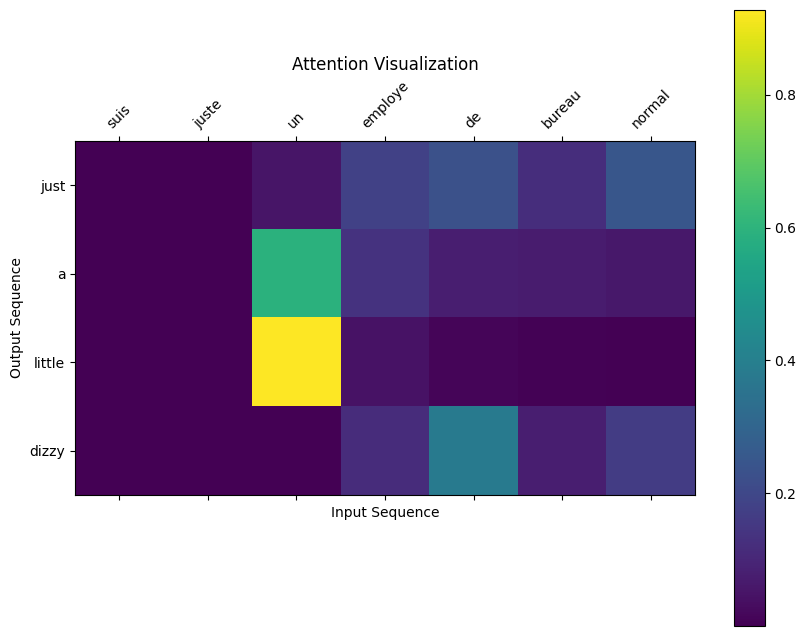

Input: suis juste un employe de bureau normal
Output: just a little dizzy




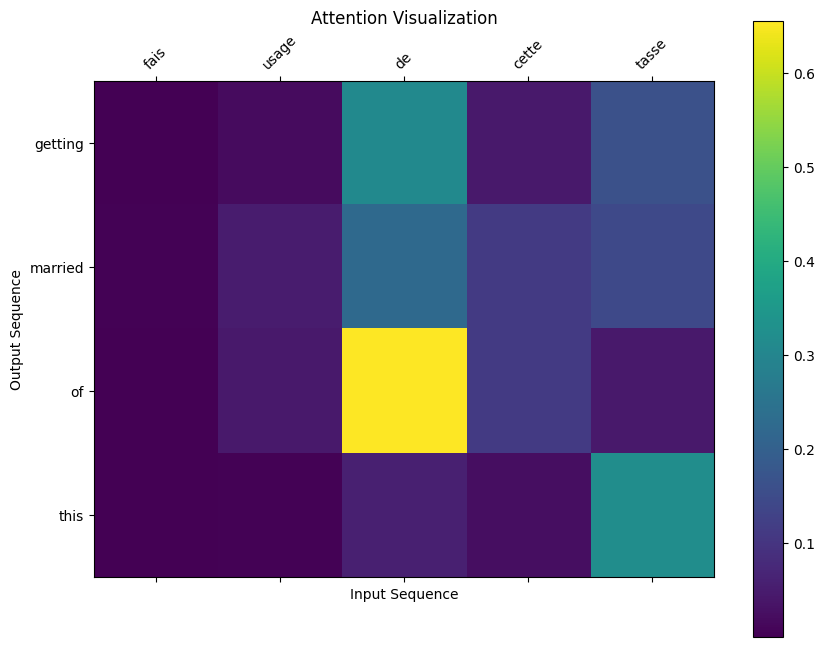

Input: fais usage de cette tasse
Output: getting married of this




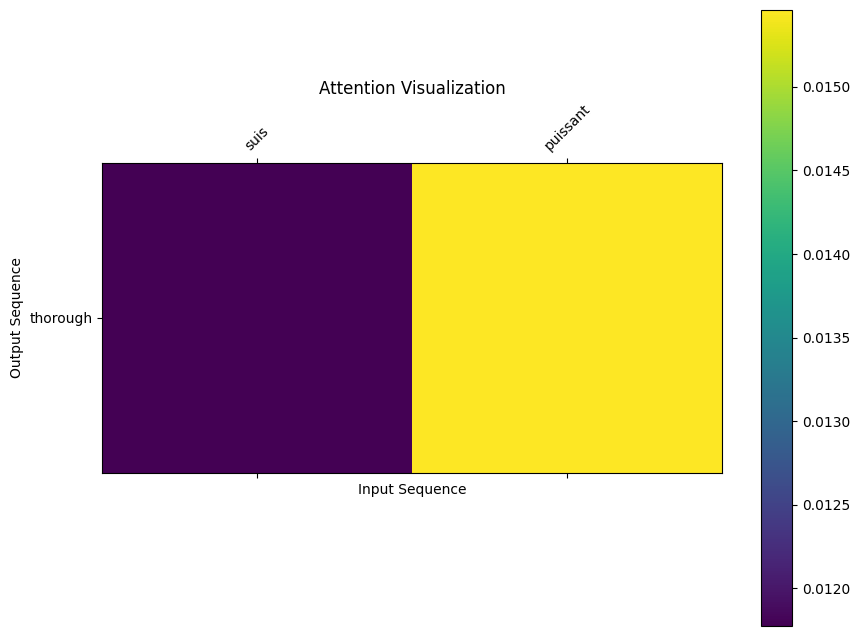

Input: suis puissant
Output: thorough


Test Loss: 3.0097
Word Accuracy: 62.27%
BLEU-4 Score: 0.3142


In [54]:
# 评估函数 evaluation function 
# 注意力可视化函数 attention visilization function
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_model(encoder, decoder, test_loader, input_lang, output_lang, criterion, max_examples=3):
    encoder.eval()
    decoder.eval()
    
    total_loss = 0
    total_correct = 0
    total_words = 0
    all_targets = []
    all_predictions = []
    attention_samples = []  # 存储可视化需要的样本
    
    with torch.no_grad():
        for batch_idx, (input_batch, target_batch) in enumerate(test_loader):
            # 前向传播
            encoder_outputs, encoder_hidden = encoder(input_batch)
            decoder_outputs, decoder_hidden, attentions = decoder(encoder_outputs, encoder_hidden)
            
            # 计算损失
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), 
                            target_batch.view(-1))
            total_loss += loss.item()
            
            # 计算准确率
            mask = (target_batch != 0)  # 忽略填充位置
            _, predicted = torch.max(decoder_outputs, dim=2)
            correct = (predicted == target_batch) * mask
            total_correct += correct.sum().item()
            total_words += mask.sum().item()
            
            # 收集BLEU需要的文本
            batch_preds, batch_targets = process_predictions(predicted, target_batch, output_lang)
            all_predictions.extend(batch_preds)
            all_targets.extend([[t] for t in batch_targets])  # BLEU需要[[ref1], [ref2], ...]
            
            # 收集前几个样本的注意力权重
            if batch_idx == 0:  # 只取第一个batch的前几个样本
                for i in range(min(max_examples, input_batch.size(0))):
                    attention_samples.append({
                        'input': input_batch[i].cpu().numpy(),
                        'output': predicted[i].cpu().numpy(),
                        'attention': attentions[i].cpu().numpy()
                    })
    
    # 计算指标
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_words if total_words > 0 else 0
    bleu = corpus_bleu(all_targets, all_predictions, 
                      smoothing_function=SmoothingFunction().method1)
    
    # 可视化注意力
    visualize_attention(attention_samples, input_lang, output_lang)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'bleu': bleu
    }

def process_predictions(predicted, targets, output_lang):
    """将索引转换为单词列表，过滤特殊标记"""
    batch_preds = []
    batch_targets = []
    
    # predicted形状: [batch_size, seq_len]
    # targets形状: [batch_size, seq_len]
    for i in range(predicted.size(0)):
        # 处理预测结果
        pred_ids = predicted[i].tolist()
        pred_words = []
        for idx in pred_ids:
            if idx == EOS_token:
                break
            if idx not in [SOS_token, 0]:
                pred_words.append(output_lang.index2word[idx])
        
        # 处理真实目标
        target_ids = targets[i].tolist()
        target_words = []
        for idx in target_ids:
            if idx == EOS_token:
                break
            if idx not in [SOS_token, 0]:
                target_words.append(output_lang.index2word[idx])
        
        batch_preds.append(pred_words)
        batch_targets.append(target_words)
    
    return batch_preds, batch_targets

def visualize_attention(samples, input_lang, output_lang):
    """可视化注意力权重"""
    for sample in samples:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
        # 处理输入输出文本
        input_ids = [idx for idx in sample['input'] if idx not in [0, EOS_token]]
        output_ids = [idx for idx in sample['output'] if idx not in [0, EOS_token, SOS_token]]
        
        input_words = [input_lang.index2word[idx] for idx in input_ids]
        output_words = [output_lang.index2word[idx] for idx in output_ids]
        
        # 调整注意力矩阵尺寸
        attention = sample['attention'][:len(output_words), :len(input_words)]
        
        # 绘制热力图
        cax = ax.matshow(attention, cmap='viridis')
        plt.colorbar(cax)
        
        # 设置坐标标签
        ax.set_xticks(range(len(input_words)))
        ax.set_yticks(range(len(output_words)))
        ax.set_xticklabels(input_words, rotation=45)
        ax.set_yticklabels(output_words)
        
        # 添加网格
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
        plt.title("Attention Visualization")
        plt.xlabel("Input Sequence")
        plt.ylabel("Output Sequence")
        plt.show()

        # 打印文本对照
        print("Input:", ' '.join(input_words))
        print("Output:", ' '.join(output_words))
        print("\n" + "="*50 + "\n")

# 定义损失函数（需要与训练时一致）
criterion = nn.NLLLoss(ignore_index=0)  # 忽略填充位置

# 加载最佳模型
encoder.load_state_dict(torch.load('/harddisk1/SZC-Project/NLP-learning/RNNs/model_saved/best_encoder.pth'))
decoder.load_state_dict(torch.load('/harddisk1/SZC-Project/NLP-learning/RNNs/model_saved/best_decoder.pth'))

# 执行评估
test_metrics = evaluate_model(
    encoder=encoder,
    decoder=decoder,
    test_loader=test_dataloader,
    input_lang=input_lang,
    output_lang=output_lang,
    criterion=criterion,
    max_examples=3  # 可视化3个示例
)

print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Word Accuracy: {test_metrics['accuracy']:.2%}")
print(f"BLEU-4 Score: {test_metrics['bleu']:.4f}")


# 2. 代码数据流展示

# 3. 模型变体尝试